### Initalizing spark

In [6]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Jonas_rentalPrice-Copy1") \
    .config("spark.executor.memory", '4g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

sc = spark.sparkContext
sqlCtx = SQLContext(sc)

Downloading the data as a pandas data frame.

In [7]:
train_data_pd = pd.read_json("data/train.json")

Taking a look at the data.

In [8]:
train_data_pd

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,high
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,low
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,low
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],40.7429,6894514,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,medium
100016,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,"[prewar, elevator, Dogs Allowed, Cats Allowed,...",40.8012,6930771,-73.9660,01287194f20de51872e81f660def4784,[https://photos.renthop.com/2/6930771_7e3622b6...,3600,210 West 107th Street,low
100020,2.0,1,0372927bcb6a0949613ef5bf893bbac7,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,"[Doorman, Elevator, Pre-War, Terrace, Laundry ...",40.7427,6867392,-73.9957,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/6867392_b18283f6...,5645,155 West 21st Street,low
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",40.8234,6898799,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,medium
100027,2.0,4,0,2016-04-02 02:58:15,This is a spacious four bedroom with every bed...,522 E 11th,"[Dishwasher, Hardwood Floors]",40.7278,6814332,-73.9808,23a01ea7717b38875f5b070282d1b9d2,[https://photos.renthop.com/2/6814332_e19a8552...,5800,522 E 11th,low


Create a pySpark DataFrame of the pandas Data Frame.

In [9]:
train_data_df = sqlCtx.createDataFrame(train_data_pd)

Printing the schema. Seems to be ok for most part. The `created` should be changed from string to time object.

In [10]:
train_data_df.printSchema()

root
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- building_id: string (nullable = true)
 |-- created: string (nullable = true)
 |-- description: string (nullable = true)
 |-- display_address: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- latitude: double (nullable = true)
 |-- listing_id: long (nullable = true)
 |-- longitude: double (nullable = true)
 |-- manager_id: string (nullable = true)
 |-- photos: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: long (nullable = true)
 |-- street_address: string (nullable = true)
 |-- interest_level: string (nullable = true)



Show the first row in the pySpark Data Frame.

In [11]:
train_data_df.show(1)

+---------+--------+--------------------+-------------------+--------------------+-------------------+--------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|bathrooms|bedrooms|         building_id|            created|         description|    display_address|features|latitude|listing_id|longitude|          manager_id|              photos|price|      street_address|interest_level|
+---------+--------+--------------------+-------------------+--------------------+-------------------+--------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|      1.5|       3|53a5b119ba8f7b61d...|2016-06-24 07:54:24|A Brand New 3 Bed...|Metropolitan Avenue|      []| 40.7145|   7211212| -73.9425|5ba989232d0489da1...|[https://photos.r...| 3000|792 Metropolitan ...|        medium|
+---------+--------+--------------------+-------------------+--------------------+--------------

Printing the `bathrooms` column and sorting on the most frequent number of bathrooms.

In [12]:
train_data_df.groupBy('bathrooms').count().sort('count', ascending=False).show()

+---------+-----+
|bathrooms|count|
+---------+-----+
|      1.0|39422|
|      2.0| 7660|
|      3.0|  745|
|      1.5|  645|
|      0.0|  313|
|      2.5|  277|
|      4.0|  159|
|      3.5|   70|
|      4.5|   29|
|      5.0|   20|
|      5.5|    5|
|      6.0|    4|
|      6.5|    1|
|     10.0|    1|
|      7.0|    1|
+---------+-----+



Checking out the apartment with 10 bathrooms.

In [13]:
train_data_df.filter(train_data_df["bathrooms"] == 10.0).show()

+---------+--------+--------------------+-------------------+--------------------+---------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+--------------+--------------+
|bathrooms|bedrooms|         building_id|            created|         description|display_address|            features|latitude|listing_id|longitude|          manager_id|              photos|price|street_address|interest_level|
+---------+--------+--------------------+-------------------+--------------------+---------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+--------------+--------------+
|     10.0|       2|424f8014bddc288d2...|2016-04-09 04:34:31|***The building?s...|       W 52 St.|[Doorman, Elevato...| 40.7633|   6849204| -73.9849|0c71a59cb70215fbf...|[https://photos.r...| 3600|  260 W 52 St.|           low|
+---------+--------+--------------------+-------------------+--------------------+------

We we that it is a room with 2 bedrooms. Highly likely that it is a typo. We continue to check out the rental with 7 and 6.5 bathrooms.

In [14]:
train_data_df.filter((train_data_df["bathrooms"] == 7.0) | (train_data_df["bathrooms"] == 6.5) ).show()

+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|bathrooms|bedrooms|         building_id|            created|         description|     display_address|            features|latitude|listing_id|longitude|          manager_id|              photos|price|      street_address|interest_level|
+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|      6.5|       7|3be1175591e290053...|2016-06-22 03:15:54|This landmark Eng...|206 Upper Mountai...|[Garage, Garden, ...| 40.8336|   7198431|  -74.216|1d019cccf631394cd...|[https://photos.r...|14500|206 Upper Mountai...|           low|
|      7.0|       5|                   0|201

We see that these are way more expensive than the rental with 10 bathrooms which further the suspision that it is a typo. 

Printing the `bedrooms` column and sorting on the most frequent number of bedrooms.

In [15]:
train_data_df.groupBy('bedrooms').count().sort('count', ascending=False).show()

+--------+-----+
|bedrooms|count|
+--------+-----+
|       1|15752|
|       2|14623|
|       0| 9475|
|       3| 7276|
|       4| 1929|
|       5|  247|
|       6|   46|
|       7|    2|
|       8|    2|
+--------+-----+



Check out the 8 room apartments.

In [16]:
train_data_df.filter((train_data_df["bedrooms"] == 8)).show()

+---------+--------+--------------------+-------------------+--------------------+----------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+----------------+--------------+
|bathrooms|bedrooms|         building_id|            created|         description| display_address|            features|latitude|listing_id|longitude|          manager_id|              photos|price|  street_address|interest_level|
+---------+--------+--------------------+-------------------+--------------------+----------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+----------------+--------------+
|      4.0|       8|2d51ec2a54cf05468...|2016-06-25 06:09:20|Gorgeous 8 bedroo...|      Greene Ave|[Hardwood Floors,...| 40.6881|   7217045| -73.9553|9ba3641676cc717a8...|                  []| 6500|  393 Greene Ave|           low|
|      3.0|       8|f8bff653aae7c7555...|2016-06-13 02:47:37|Please note tha

We check for the `building_id` and conclude that we have 8286 missing values here.

In [17]:
train_data_df.groupBy('building_id').count().sort('count', ascending=False).show(5)

+--------------------+-----+
|         building_id|count|
+--------------------+-----+
|                   0| 8286|
|96274288c84ddd7d5...|  275|
|11e1dec9d14b1a9e5...|  215|
|80a120d6bc3aba97f...|  213|
|bb8658a3e432fb62a...|  212|
+--------------------+-----+
only showing top 5 rows



Displaying the `created` column.

In [18]:
train_data_df[["created"]].show(5)

+-------------------+
|            created|
+-------------------+
|2016-06-24 07:54:24|
|2016-06-12 12:19:27|
|2016-04-17 03:26:41|
|2016-04-18 02:22:02|
|2016-04-28 01:32:41|
+-------------------+
only showing top 5 rows



Changing the `created` column to timestamp objects instead of strings.

In [19]:
train_data_df = train_data_df.withColumn("created", F.to_timestamp("created"))

We create a coulm called `Day_of_week` which contains the day of the week the rental was created.

In [20]:
day_of_week = train_data_df.withColumn("Day_of_week", F.dayofweek(train_data_df["created"]))
day_of_week = day_of_week[["Day_of_week"]]
day_of_week.show(5)

+-----------+
|Day_of_week|
+-----------+
|          6|
|          1|
|          1|
|          2|
|          5|
+-----------+
only showing top 5 rows



We want to plot the count of the different days that the rental was created.

In [21]:
day_of_week_pd = day_of_week.toPandas()

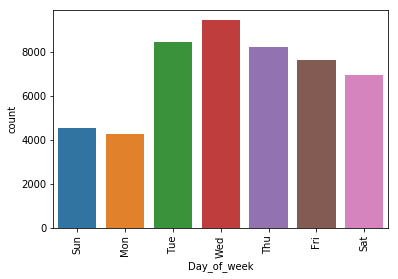

In [22]:
ax = sns.countplot(x="Day_of_week", data = day_of_week_pd)
ax.set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"], rotation='vertical', fontsize=10)
plt.show()

We create a data frame with `longitude` and `latitude` in order to plot the positioning of the rental unit on a map.

In [23]:
long_lat_df = train_data_df[["longitude", "latitude"]]

In [24]:
long_lat_df.show(5)

+---------+--------+
|longitude|latitude|
+---------+--------+
| -73.9425| 40.7145|
| -73.9667| 40.7947|
| -74.0018| 40.7388|
| -73.9677| 40.7539|
| -73.9493| 40.8241|
+---------+--------+
only showing top 5 rows



Printing a statistic summary, mostly to see if there were any strange values. Which there were since we dont think that there are any rental units with longitude and latitude = 0.0

In [25]:
long_lat_df.describe().show()

+-------+------------------+------------------+
|summary|         longitude|          latitude|
+-------+------------------+------------------+
|  count|             49352|             49352|
|   mean|-73.95571552115403| 40.74154482290473|
| stddev|1.1779119215716698|0.6385353439544786|
|    min|          -118.271|               0.0|
|    max|               0.0|           44.8835|
+-------+------------------+------------------+



We see how many rental units that have longitude and latitude = 0.0

In [26]:
print("Number of observations with missing longitude: {}" .format(long_lat_df.filter(long_lat_df["longitude"] == 0.0).count()))
print("Number of observations with missing latitude: {}" .format(long_lat_df.filter(long_lat_df["latitude"] == 0.0).count()))

Number of observations with missing longitude: 12
Number of observations with missing latitude: 12


Could these be the same observations?

In [27]:
print("Number of observations with missing longitude and latitude: {}".format(long_lat_df.filter((long_lat_df["latitude"] == 0.0) & (long_lat_df["longitude"] == 0.0)).count()))

Number of observations with missing longitude and latitude: 12


Yes they are... So how many are remaining?

In [28]:
long_lat_df.filter(long_lat_df["latitude"] != 0.0).count()

49340

To plot the apartments we use the package `folium` which can make interactive plots and we can get more information of the rental units in the plot.

Inspiration from blogpost: https://nbviewer.jupyter.org/github/vincentropy/python_cartography_tutorial/blob/master/part1_basic_folium_maps.ipynb

In [29]:
#!pip install --upgrade folium
import folium

We create a function that places each of the units on the map. The color of the apartment corresponds to the factor `interest_level` which has not been investigated thoroughly yet. The size of the circle is based on the price which can be displayed by *klicking* the circle, along with the `street_address`.

In [39]:
def plot_rental_locatinos(rental_locatinos):
        # generate a new map
    folium_map = folium.Map(location=[40.738, -73.98],
                            zoom_start=13,
                            tiles="CartoDB dark_matter",
                            width='50%')

            
    for index, row in rental_locatinos.iterrows():
        
            popup_text = "{}<br> Price: {}<br>"
            popup_text = popup_text.format(row["street_address"], row["price"])
            
            if row["interest_level"] == 'high':
                color="#007849" # green
            if row["interest_level"] == 'medium':
                color="#FFCE00" # yellow 
            if row["interest_level"] == 'low':
                color="#FFCE99" # orange
                
            radius = row["price"]/1000
        
            folium.CircleMarker(location=(row["latitude"],
                                      row["longitude"]),
                            radius=radius,
                            color=color,
                            popup=popup_text,
                            fill=True).add_to(folium_map)
    return folium_map

Since our data set is too big for all rental units to be displayed a subsample of 1000 units are changed into a pandas data frame which is then plotted using the above constructed function `plot_rental_locatinos`.

In [31]:
sample_pd = train_data_pd.sample(n = 1000)

The user constructed function `plot_rental_locatinos`

In [40]:
plot_rental_locatinos(sample_pd)

We want to explode and split on the column `features`. So that each feature gets it's own column with binary values.

In [33]:
list = train_data_df[["features"]].collect()[1][0]
list

['Doorman', 'Elevator', 'Fitness Center', 'Cats Allowed', 'Dogs Allowed']

We first have to handele the rentals with missing featurses by adding `missing` as a feature. Here are the 2 first listings with missing features.

In [34]:
train_data_df.filter(F.size("features")==0).show(2)

+---------+--------+--------------------+-------------------+--------------------+-------------------+--------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|bathrooms|bedrooms|         building_id|            created|         description|    display_address|features|latitude|listing_id|longitude|          manager_id|              photos|price|      street_address|interest_level|
+---------+--------+--------------------+-------------------+--------------------+-------------------+--------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|      1.5|       3|53a5b119ba8f7b61d...|2016-06-24 07:54:24|A Brand New 3 Bed...|Metropolitan Avenue|      []| 40.7145|   7211212| -73.9425|5ba989232d0489da1...|[https://photos.r...| 3000|792 Metropolitan ...|        medium|
|      2.0|       4|38a913e46c94a7f46...|2016-04-19 04:24:47|                    |   West 18th S

In [35]:
def fillMissing(features):
    if(len(features) == 0): return ['Missing Feature']
    else : return features

fill_missing_udf = F.udf(fillMissing)

train_data_df2 = train_data_df.withColumn("features" , fill_missing_udf(F.col("features")))

In [36]:
train_data_df2[["features"]].show(10)

+--------------------+
|            features|
+--------------------+
|   [Missing Feature]|
|[Doorman, Elevato...|
|[Laundry In Build...|
|[Hardwood Floors,...|
|           [Pre-War]|
|   [Missing Feature]|
|[prewar, elevator...|
|[Doorman, Elevato...|
|[Cats Allowed, Do...|
|[Dishwasher, Hard...|
+--------------------+
only showing top 10 rows



In [38]:
train_data_df2[["features"]].collect()[1][0]

'[Doorman, Elevator, Fitness Center, Cats Allowed, Dogs Allowed]'

In [ ]:
train_data_df2.withColumn("ex_features", F.explode(train_data_df2.features)).show(5)

In [ ]:
train_data_df.withColumn("ex_features", F.explode(train_data_df.features)).show(5)

In [ ]:
train_data_rdd = train_data_df.rdd

In [ ]:
def feature_processor(row):
    return [row[ticker] for ticker in row.__fields__]

In [ ]:
train_data_rdd.map(lambda row: feature_processor(row)).take(1)

In [ ]:
import re

Removes numbers of adresses?

In [ ]:
def addressProcessor(address):
    addressTokens = address.split(" ")
    result = []
    for ticker in addressTokens:
        if re.match("^[0-9]+$",ticker):
            continue
        else:
            result.append(ticker)
    return " ".join(result).lower().strip().replace(".","")

In [ ]:
addressProcessor("a jda 12")

In [ ]:
resultDict = dict()
display_address = train_data_pd.get("display_address")
for i in display_address:
    resultDict[i] = addressProcessor(i)
resultDict